# **Aspect Based Sentiment Analysis on Yelp Customer Reviews**


## **Motivation and objectives** : 

The reputation of any business entity is driven by its customer ratings and reviews. The hospitality industry is no exception to this rule, and the reputation of restaurants as well depends on the same. 

Positive reviews can lead to increase in business revenue, whereas negative ones can drive away potential customers and affect the business prestige, profitability and trustworthiness.

Customers search for restaurants in search engines and/or local-search services like Yelp.com. Nowadays everyone checks online rating and reviews before visiting the restaurant. Ratings displayed online gives an overall review of the restaurant, but fails to provide details regarding important features/aspect like the quality of food, quality of service, ambience, cleanliness, price, etc. 

Currently, customers have to read through the reviews, to analyze the restaurant and select the one that best suits their personal preferences. If a customer wants to know the restaurant rating based on some specific aspects they have to read many reviews and check if any review mentions something about it.

To make the process of finding restaurants more personalized and convenient, we have come up with a project idea to create a model that provides ratings for different aspects of the restaurants based on the customer reviews on Yelp.

## **Introduction, related work, and what's new:**

In our project we have planned to label/tag each review based context of the review. The context (basically aspects in nlp) is categorized into four categories which are mentioned below: 

1.  Ambience
2.  Cleanliness
3.  Food
4.  Service

Each review is rated based on these aspects. The ratings are computed by peforming sentiment analysis on the reviews based on each and every aspect it involves. 

The related work to our project is also perfomed in semEval 2016 (http://alt.qcri.org/semeval2016).


## **Agenda - Final Project  Report**
1. EDA
    1. Dataset Description
    2. Null Values
    3. Data Visualization
    4. Naive sentiment analysis
2. Text classification
    1. Classification with logistic regression
    2. Classification with CNN
    3. Accuracy comparison for the algorithms
    4. Topic modeling with LDA
3. Extracting aspect terms
    1. Word-to-vec for extracting aspect terms
    2. Word cloud for each aspect term
4. Aspect based sentiment analysis
    1. Sentence tokenization
    2. POS tagging
    3. Polarity based sentiment mining
5. Inference
    1. Average rating of a restaurant with naive sentiment analysis Vs Aspect based ratings of a restaurant
    2. What kind of questions our application can answer now
6. Future work
    1. What kind of questions we want our application to answer in the future

## Project Description

This project aims to give detailed ratings for restaurants based on customer reviews and ratings. The features considered are: service, ambience, food(taste, quality, etc.), and cleanliness. Each restaurant will be given ratings for each of these features after analyzing customer reviews. The Yelp dataset is being used for this analysis. It's available online and can be downloaded from the link below:

https://www.yelp.com/dataset

## Dataset

The dataset is downloaded from Yelp official website. It has reviews for business entities in the United States of America and Canada. The downloaded data is in JSON format. It has 6 files: business.json, review.json, user.json, checkin.json, tip.json, and photo.json. The file that will be of interest to us is review.json.

The Yelp dataset has reviews for different business entities such as Groceries, Furnitures, Plumbing, etc. apart from restaurant reviews. So the dataset has around 6 million reviews.



## Data Preprocessing

Since the data had business entities apart from restaurants, our first step was to filter businesses and reviews that belong to restaurant domain. The following extracts restaurant business from business.json file.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def filter_restaurant_businesses(file):
    df = pd.read_json(file, lines=True)
    filtered_df = df[(df.categories.str.contains('Restaurants')==True) & (df.state.str.contains('IL')==True)]
    il_business = filtered_df.business_id.to_string(index=False)
    with open('./il_business_ids.txt', 'w') as outfile:
        outfile.write(il_business)
        
    categories_dict = {'business_id': filtered_df.business_id.to_list(), 'categories': filtered_df.categories.to_list(), 'state': filtered_df.state.to_list()}    
    restaurant_df = pd.DataFrame(data=categories_dict)
    grouped_by_states = restaurant_df[['business_id', 'categories', 'state']].groupby(['state']).agg(['count'])
    print(grouped_by_states) #59371 restaurants in all. NY restaurants - 12. IL - 672
    
    with open("./il_business_ids.txt","r") as il_business_ids:
    sample = il_business_ids.readline()
    print(sample)

By filtering the restaurant businesses and grouping them by states, the following are some statistics that was observed: 
* There are 59,371 restaurants in total
* The state-wide restaurant count: 
          
state - restaurant count<br>                       
AB  -    3035<br>
AL  -     1<br>
AR  -       1<br>
AZ  -   11465<br>
BC  -       1<br>
CA  -       1<br>
CON -       1<br>
FL  -       1<br>
IL  -     672<br>
NC  -    4326<br>
NE  -       1<br>
NM  -       1<br>
NV  -    7783<br>
NY  -      12<br>
OH  -    5522<br>
ON  -   14831<br>
PA  -    4001<br>
QC  -    5622<br>
SC  -     384<br>
TX  -       1<br>
VA  -       1<br>
VT  -       1<br>
WA  -       1<br>
WI  -    1703<br>
XGM -       1<br>
XWY -       2<br>


#### We decided to use retaurants in Illinois for our analysis. 

*   The business ids that belong to Illinois state are extracted and stored in a file named "il_business_ids.txt".
*   The review.json file is very large to work with so, we have split it into blocks using the following command and save these blocks of reviews into reviews_2000000.json.



head -2000000 review.json > reviews_2000000.json

Now, the IL_Reviews are filtered out from  reviews_2000000.json data by matching the business id's from "il_business_ids.txt" and stroed into a csv file.

In [0]:
def filter_il_reviews(file):
    df = pd.read_json(file, lines=True)
    business_ids = df.business_id.to_list()
    df.set_index('business_id', inplace=True)
    reviews_df = pd.DataFrame()

    with open('./il_business_ids.txt', 'r') as infile:
        for b_id in infile:
            b_id = b_id.strip()
            if b_id in business_ids:
                data = df.loc[[b_id]]
                reviews_df = reviews_df.append(data)
    with open('./il_reviews.csv', 'a') as outfile:
        reviews_df.to_csv(outfile, header=False)

**The Filtered Dataset:**

In [36]:
import pandas as pd

reviews_data = pd.read_csv("../data/il_reviews.csv")

reviews_data.head(2)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,mofOjB6flg-eAWOFbOkHfQ,0,12/2/2017 20:22,0,8MTptiOpUeuPUFZgtfk9Vw,1,I would have given this restaurant zero stars ...,1,9-vNlkNQL7OJQZ7-U965Ww
1,mofOjB6flg-eAWOFbOkHfQ,0,12/16/2017 4:31,0,ofpfzn8LV4nJ2pE6IlTVdg,1,So...no. Just...no. Before I picked up a plate...,1,#NAME?


# Exploratory Data Analysis

##1. Dataset Description
          
  The dataset consists of 6703 samples of reviews and the dataset profile can be analyzed below:

1.   Total number of restaurants - 184
2.   Maximum reviews - 173
3.   Minimum reviews - 3

In [10]:
reviews_data.describe()

,cool,funny,stars,useful
count,6703.000000,6703.000000,6703.000000,6703.000000
mean,0.332836,0.374907,3.476652,1.215277
std,0.902303,1.434581,1.441803,2.218730
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,2.000000,0.000000
50%,0.000000,0.000000,4.000000,0.000000
75%,0.000000,0.000000,5.000000,2.000000
max,16.000000,37.000000,5.000000,38.000000


In [11]:
reviews_data.corr()

,cool,funny,stars,useful
cool,1.000000,0.386800,0.095492,0.608676
funny,0.386800,1.000000,-0.133010,0.363115
stars,0.095492,-0.133010,1.000000,-0.064078
useful,0.608676,0.363115,-0.064078,1.000000


Cool, funny and useful describes the number of cool, funny and useful votes given to the review. From the above dataset description, it is observed that less than 25% of the reviewers has voted the reviews as cool, funny or useful. So, the cool, funny and useful votes data is not useful for our project model. Also, columns such as user_id is irrelevant for further analysis.

So, we decided to remove these columns from the dataset.

In [12]:
reviews_data.drop(["cool","date","funny","useful", "user_id"],axis = 1,inplace=True) # dropping cool, date, funny and useful columns
reviews_data.sample()

,business_id,review_id,stars,text
184,pCer-vIZM05p423MFmiSng,U6wNslpXKu2LIWguBEfFYg,3,Location is good. they have interesting sushi ...


## 2. Null Values

No null values were found in the dataset

In [41]:
text = reviews_data['text']
print ("Reviews with NULL values:")
print (reviews_data['text'].isnull().sum())

restaurant = reviews_data['business_id']
print ("Restaurant ids with NULL values:")
print (restaurant.isnull().sum())

ratings = reviews_data['stars']
print ("Ratings with NULL values:")
print (ratings.isnull().sum())


Reviews with NULL values:
0
Restaurant ids with NULL values:
0
Ratings with NULL values:
0


## 3. Data Visualization

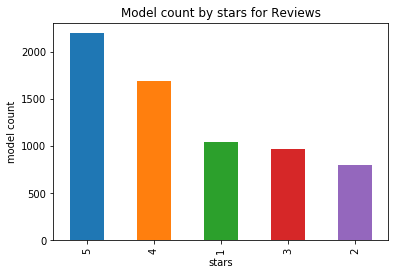

In [14]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

# plotting the stars rating againt count
ax = reviews_data.stars.value_counts().plot.bar(figsize=(6,4), title="Model count by stars for Reviews");  
ax.set(xlabel = "stars", ylabel = "model count");

From the above chart, we can analyze that the majority of reviews have received 5 start ratings and 50% of the reviews have 1 star rating.

#### Average rating for each restaurant

<img src="./Images/Average_rating_business_ids.png" width='50%'>

# Naive Sentimental Analysis

Naive sentiment analysis is performed to get a feel of the dataset and the have a sense of the review sentiments for further analysis.

In [28]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.preprocessing.text import Tokenizer


# Reading positive and negative words text file
with open("./Sentimental_Analysis_Text_File/positive-words.txt",'r') as f:
    positive_words=[line.strip() for line in f]
with open("./Sentimental_Analysis_Text_File/negative-words.txt",'r') as f:
    negative_words=[line.strip() for line in f]
    
# Reading positive and negative words text file
df = pd.read_csv("../data/il_reviews.csv")

df.drop(["cool","date","funny","useful"],axis = 1,inplace=True)

# Pre-processing Reviews data
processedData = list(df[["business_id","text","user_id"]].as_matrix())

# Performs naive Sentiment Analysis 
def naive_sentiment(x):
    res = []
    ans = []
    positive_tokens=[]
    negative_tokens=[]
    negations=['not', 'too', 'n\'t', 'no', 'cannot', 'neither','nor']
    final_review=[]
    data = x[1]
    for val in sent_tokenize(data):
        val = val.strip(string.punctuation)
        for token in word_tokenize(val):
            if token in positive_words:   
                  positive_tokens.append(token)
            else:
                  if token in negative_words:
                        negative_tokens.append(token)
                    
    if len(positive_tokens)>len(negative_tokens):
        final_review.append("positive")  
    else:
        if len(negative_tokens)>len(positive_tokens):
            final_review.append("negative")
        else:
            if len(positive_tokens)==len(negative_tokens):
                final_review.append("neutral")  
    return final_review

C:\Users\harsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [27]:
processed_doc = list(map(naive_sentiment,processedData))

NameError: name 'sent_tokenize' is not defined

Plotting the naive sentiment analysis results below:

In [29]:
review_sentiment = []

for x in processed_doc:
    review_sentiment+=x
    
df['sentiment'] = review_sentiment

ax = df.sentiment.value_counts().plot.bar(figsize=(6,4), title="Model count by sentiment");  
ax.set(xlabel = "sentiment", ylabel = "model count");
plt.show()

NameError: name 'processed_doc' is not defined

From the above graph it can be analysed that the majority of reviews are positive. Less than 1000 reviews are negative and approximately less than 700 reviews are neutral.

This obeservation leads to conclude that the dataset is imbalanced and it is further investigated in detail.

 